In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats
from scipy.stats import wilcoxon

In [3]:
# list of dates for vns sessions and no vns sessions
vns_sessions = ['2019-01-22 15:10:00','2019-01-22 16:01:00','2019-01-23 15:39:00','2019-01-29 16:02:00','2019-01-30 16:38:00','2019-02-01 15:03:00']
no_vns = ['2018-12-19 11:02:00','2018-12-19 11:31:00','2018-12-19 15:30:00','2018-12-19 15:57:00','2018-12-19 16:27:00','2018-12-19 17:24:00','2018-12-20 14:56:00','2018-12-20 15:55:00',
          '2018-12-20 16:57:00','2018-12-21 14:56:00','2019-01-14 14:44:00','2019-01-14 16:21:00','2019-01-15 14:28:00','2019-01-15 16:16:00','2019-01-16 14:29:00','2019-01-17 14:54:00',
          '2019-01-17 16:21:00','2019-01-18 14:22:00','2019-01-18 15:58:00','2019-01-22 14:41:00','2019-01-22 16:19:00','2019-01-23 14:31:00','2019-01-24 15:06:00','2019-01-29 14:42:00',
          '2019-01-30 14:59:00','2019-01-31 14:31:00','2019-01-31 16:11:00','2019-02-01 16:08:00']

In [7]:
# read in files
vns_on_eye_noBlinks = pd.read_pickle("./data/vns_no_blinks.pkl")
vns_off_eye_noBlinks = pd.read_pickle("./data/noVNS_no_blinks.pkl")
vns_on_trials = pd.read_pickle("./data/vns_on_trials.pkl")
vns_off_trials = pd.read_pickle("./data/vns_off_trials.pkl")

In [85]:
# compute average pupil voltage in 0.5 s BEFORE target comes on (i.e. trial baseline) and 0.5 s AFTER (i.e. post trial) --> VNS
trials_df = pd.DataFrame()
baseline_df = pd.DataFrame()
post_df = pd.DataFrame()
slope_df = pd.DataFrame()
avg_df = pd.DataFrame()
for date in range(0,len(vns_sessions)):
    print(vns_sessions[date])
    mean_baselineON = [np.NaN] * (len(vns_on_eye_noBlinks[vns_on_eye_noBlinks['Session'] == vns_sessions[date]].Trial.unique()))
    mean_postON = [np.NaN] * (len(vns_on_eye_noBlinks[vns_on_eye_noBlinks['Session'] == vns_sessions[date]].Trial.unique()))
    trial_typeON = [np.NaN] * (len(vns_on_eye_noBlinks[vns_on_eye_noBlinks['Session'] == vns_sessions[date]].Trial.unique()))
    slope_ON = [np.NaN] * (len(vns_on_eye_noBlinks[vns_on_eye_noBlinks['Session'] == vns_sessions[date]].Trial.unique()))
    avg_ON = [np.NaN] * (len(vns_on_eye_noBlinks[vns_on_eye_noBlinks['Session'] == vns_sessions[date]].Trial.unique()))
    for x in range(0,len(vns_on_eye_noBlinks[vns_on_eye_noBlinks['Session'] == vns_sessions[date]].Trial.unique())):
        session = vns_on_eye_noBlinks.loc[(vns_on_eye_noBlinks['Session'] == vns_sessions[date]) & (vns_on_eye_noBlinks['Trial'] == x),'Pupils'].interpolate()
        if (vns_on_trials.loc[(vns_on_trials['Session'] == vns_sessions[date]),'good_trials'].loc[x] == 1):
            trial_on = vns_on_trials.loc[(vns_on_trials['Session'] == vns_sessions[date]),'time_target_on'].loc[x]
            fp_off = vns_on_trials.loc[(vns_on_trials['Session'] == vns_sessions[date]),'time_fp_off'].loc[x]
            baseline = trial_on - 0.5
            post = trial_on + 0.5
            trial_on = '%.3f'%(trial_on)
            fp_off = '%.3f'%(fp_off)
            baseline = '%.3f'%(baseline)
            post = '%.3f'%(post)
            trial_on = intro + trial_on + end
            fp_off = intro + fp_off + end
            baseline = intro + baseline + end
            post = intro + post + end
            trial_on_idx = session.index.get_loc(trial_on, method = 'nearest')
            fp_idx = session.index.get_loc(fp_off, method = 'nearest')
            baseline_idx = session.index.get_loc(baseline, method = 'nearest')
            post_idx = session.index.get_loc(post, method = 'nearest')
            baseline_series = session[baseline_idx : trial_on_idx]
            post_series = session[trial_on_idx : post_idx]
            fp_series = session[:fp_idx]
            x_vals = pd.Series(range(trial_on_idx, (post_idx)))
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,post_series)
            slope_ON[x] = slope
            avg_base = baseline_series.mean()
            avg_post = post_series.mean()
            avg_pupil = fp_series.mean()
            mean_baselineON[x] = avg_base
            mean_postON[x] = avg_post
            avg_ON[x] = avg_pupil
            trial_typeON[x] = vns_on_trials.loc[(vns_on_trials['Session'] == vns_sessions[date]),'trial_type'].loc[x]
        
    mean_baselineON = [x for x in mean_baselineON if (np.isnan(x) == False)]
    mean_baselineON = pd.Series(mean_baselineON)
    mean_postON = [x for x in mean_postON if (np.isnan(x) == False)]
    mean_postON = pd.Series(mean_postON)
    avg_ON = [x for x in avg_ON if (np.isnan(x) == False)]
    avg_ON = pd.Series(avg_ON)
    trial_typeON = [x for x in trial_typeON if (np.isnan(x) == False)]
    trial_typeON = pd.Series(trial_typeON)
    slope_ON = [x for x in slope_ON if (np.isnan(x) == False)]
    slope_ON = pd.Series(slope_ON)
    trials_df = pd.concat([trials_df,trial_typeON], ignore_index = True, axis = 1)
    baseline_df = pd.concat([baseline_df, mean_baselineON], ignore_index = True, axis = 1)
    post_df = pd.concat([post_df, mean_postON], ignore_index = True, axis = 1)
    slope_df = pd.concat([slope_df, slope_ON], ignore_index = True, axis = 1)
    avg_df = pd.concat([avg_df, avg_ON], ignore_index = True, axis = 1)

2019-01-22 15:10:00
2019-01-22 16:01:00
2019-01-23 15:39:00
2019-01-29 16:02:00
2019-01-30 16:38:00
2019-02-01 15:03:00


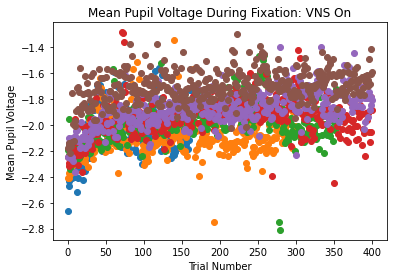

In [94]:
# make a scatter plot of the mean pupil voltage in every trial during the time the animal is fixating (i.e. from start until time_fp_off) --> VNS ON
plt.plot(avg_df, linestyle = 'none', marker = 'o')
plt.xlabel('Trial Number')
plt.ylabel('Mean Pupil Voltage')
plt.title('Mean Pupil Voltage During Fixation: VNS On')
mean_volt_on = plt.gcf()
plt.show()
mean_volt_on.savefig('mean_volt_on.png', dpi = 100)

In [11]:
# VNS ON: create dataframe percent_change_on which contains the average percent change per session, separated by the 4 trial types
# p_vals_on contains the p-value from wilcoxon test on the difference between post_pupils and baseline_pupils
p_vals_on = pd.DataFrame(columns = [0,1,2,3,4,5], index = [0,1,2,3])
percent_change_on = pd.DataFrame(columns = [0,1,2,3,4,5], index = [0,1,2,3])
for sess in range(0,6):
    # erpd_on created for each session; df containing info on trial type, avg baseline, and avg post for each trial in that session
    erpd_on = pd.DataFrame({'Trial Type' : trials_df[sess], 'Baseline' : baseline_df[sess], 'Post' : post_df[sess]})
    trials = [6101, 6111, 6102, 6112]
    for t in range(0, len(trials)):
        baseline_pupils = erpd_on.loc[(erpd_on['Trial Type'] == trials[t]),'Baseline']
        post_pupils = erpd_on.loc[(erpd_on['Trial Type'] == trials[t]),'Post']
        #print(baseline_pupils.mean(skipna = True))
        #print(post_pupils.mean(skipna = True))
        difference = post_pupils - baseline_pupils
        stat, p = wilcoxon(difference)
        percent_change = sum((difference / (-1*baseline_pupils))*100)/len((difference))
        p_vals_on.iloc[t, sess] = p
        percent_change_on.iloc[t, sess] = percent_change

In [54]:
# compute average pupil voltage in 0.5 s BEFORE target comes on (i.e. trial baseline) and 0.5 s AFTER (i.e. post trial) --> no VNS
trials_df_off = pd.DataFrame()
baseline_df_off = pd.DataFrame()
post_df_off = pd.DataFrame()
slope_df_off = pd.DataFrame()
avg_df_off = pd.DataFrame()
for date in range(0,len(no_vns)):
    print(no_vns[date])
    mean_baselineOFF = [np.NaN] * (len(vns_off_eye_noBlinks[vns_off_eye_noBlinks['Session'] == no_vns[date]].Trial.unique()))
    mean_postOFF = [np.NaN] * (len(vns_off_eye_noBlinks[vns_off_eye_noBlinks['Session'] == no_vns[date]].Trial.unique()))
    trial_typeOFF = [np.NaN] * (len(vns_off_eye_noBlinks[vns_off_eye_noBlinks['Session'] == no_vns[date]].Trial.unique()))
    slope_OFF = [np.NaN] * (len(vns_off_eye_noBlinks[vns_off_eye_noBlinks['Session'] == no_vns[date]].Trial.unique()))
    avg_OFF = [np.NaN] * (len(vns_off_eye_noBlinks[vns_off_eye_noBlinks['Session'] == no_vns[date]].Trial.unique()))
    for x in range(0,len(vns_off_eye_noBlinks[vns_off_eye_noBlinks['Session'] == no_vns[date]].Trial.unique())):
        session = vns_off_eye_noBlinks.loc[(vns_off_eye_noBlinks['Session'] == no_vns[date]) & (vns_off_eye_noBlinks['Trial'] == x),'Pupils'].interpolate()
        if ((vns_off_trials.loc[(vns_off_trials['Session'] == no_vns[date]),'good_trials'].loc[x] == 1) & (vns_off_trials.loc[(vns_off_trials['Session'] == no_vns[date]),'time_target_on'].loc[x] > 0)):
            trial_on = vns_off_trials.loc[(vns_off_trials['Session'] == no_vns[date]),'time_target_on'].loc[x]
            fp_off = vns_off_trials.loc[(vns_off_trials['Session'] == no_vns[date]),'time_fp_off'].loc[x]
            baseline = trial_on - 0.5
            post = trial_on + 0.5
            trial_on = '%.3f'%(trial_on)
            fp_off = '%.3f'%(fp_off)
            baseline = '%.3f'%(baseline)
            post = '%.3f'%(post)
            trial_on = intro + trial_on + end
            fp_off = intro + fp_off + end
            baseline = intro + baseline + end
            post = intro + post + end
            trial_on_idx = session.index.get_loc(trial_on, method = 'nearest')
            fp_idx = session.index.get_loc(fp_off, method = 'nearest')
            baseline_idx = session.index.get_loc(baseline, method = 'nearest')
            post_idx = session.index.get_loc(post, method = 'nearest')
            baseline_series = session[baseline_idx : trial_on_idx]
            post_series = session[trial_on_idx : post_idx]
            fp_series = session[:fp_idx]
            x_vals = pd.Series(range(trial_on_idx, (post_idx)))
            slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,post_series)
            slope_OFF[x] = slope
            avg_base = baseline_series.mean()
            avg_post = post_series.mean()
            avg_pupil = fp_series.mean()
            mean_baselineOFF[x] = avg_base
            mean_postOFF[x] = avg_post
            avg_ON[x] = avg_pupil
            trial_typeOFF[x] = vns_off_trials.loc[(vns_off_trials['Session'] == no_vns[date]),'trial_type'].loc[x]
        
    mean_baselineOFF = [x for x in mean_baselineOFF if (np.isnan(x) == False)]
    mean_baselineOFF = pd.Series(mean_baselineOFF)
    mean_postOFF = [x for x in mean_postOFF if (np.isnan(x) == False)]
    mean_postOFF = pd.Series(mean_postOFF)
    avg_ON = [x for x in avg_ON if (np.isnan(x) == False)]
    avg_ON = pd.Series(avg_ON)
    trial_typeOFF = [x for x in trial_typeOFF if (np.isnan(x) == False)]
    trial_typeOFF = pd.Series(trial_typeOFF)
    slope_OFF = [x for x in slope_OFF if (np.isnan(x) == False)]
    slope_OFF = pd.Series(slope_OFF)
    trials_df_off = pd.concat([trials_df_off, trial_typeOFF], ignore_index = True, axis = 1)
    baseline_df_off = pd.concat([baseline_df_off, mean_baselineOFF], ignore_index = True, axis = 1)
    post_df_off = pd.concat([post_df_off, mean_postOFF], ignore_index = True, axis = 1)
    slope_df_off = pd.concat([slope_df_off, slope_OFF], ignore_index = True, axis = 1)
    avg_df_off = pd.concat([avg_df_off, avg_ON], ignore_index = True, axis = 1)

2018-12-19 11:02:00
2018-12-19 11:31:00
2018-12-19 15:30:00
2018-12-19 15:57:00
2018-12-19 16:27:00
2018-12-19 17:24:00
2018-12-20 14:56:00
2018-12-20 15:55:00
2018-12-20 16:57:00
2018-12-21 14:56:00
2019-01-14 14:44:00
2019-01-14 16:21:00
2019-01-15 14:28:00
2019-01-15 16:16:00
2019-01-16 14:29:00
2019-01-17 14:54:00
2019-01-17 16:21:00
2019-01-18 14:22:00
2019-01-18 15:58:00
2019-01-22 14:41:00
2019-01-22 16:19:00
2019-01-23 14:31:00
2019-01-24 15:06:00
2019-01-29 14:42:00
2019-01-30 14:59:00
2019-01-31 14:31:00
2019-01-31 16:11:00
2019-02-01 16:08:00


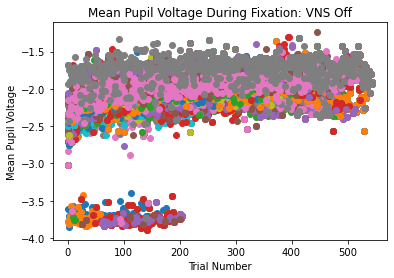

In [95]:
# make a scatter plot of the mean pupil voltage in every trial during the time the animal is fixating (i.e. from start until time_fp_off) --> VNS OFF
plt.plot(avg_df_off.iloc[:,0:28], linestyle = 'none', marker = 'o')
plt.xlabel('Trial Number')
plt.ylabel('Mean Pupil Voltage')
plt.title('Mean Pupil Voltage During Fixation: VNS Off')
mean_volt_off = plt.gcf()
plt.show()
mean_volt_off.savefig('mean_volt_off.png', dpi = 100)

In [14]:
# VNS OFF: create dataframe percent_change_on which contains the average percent change per session, separated by the 4 trial types
# p_vals_off contains the p-value from wilcoxon test on the difference between post_pupils and baseline_pupils
p_vals_off = pd.DataFrame(columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], index = [0,1,2,3])
percent_change_off = pd.DataFrame(columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27], index = [0,1,2,3])
for sess in range(0,28):
    # erpd_off created for each session; df containing info on trial type, avg baseline, and avg post for each trial in that session
    erpd_off = pd.DataFrame({'Trial Type' : trials_df_off[sess], 'Baseline' : baseline_df_off[sess], 'Post' : post_df_off[sess]})
    trials = [6101, 6111, 6102, 6112]
    for t in range(0, len(trials)):
        baseline_pupils = erpd_off.loc[(erpd_off['Trial Type'] == trials[t]),'Baseline']
        post_pupils = erpd_off.loc[(erpd_off['Trial Type'] == trials[t]),'Post']
        #print(baseline_pupils.mean(skipna = True))
        #print(post_pupils.mean(skipna = True))
        difference = post_pupils - baseline_pupils
        stat, p = wilcoxon(difference)
        percent_change = sum((difference / (-1*baseline_pupils))*100)/len(difference)
        p_vals_off.iloc[t, sess] = p
        percent_change_off.iloc[t, sess] = percent_change

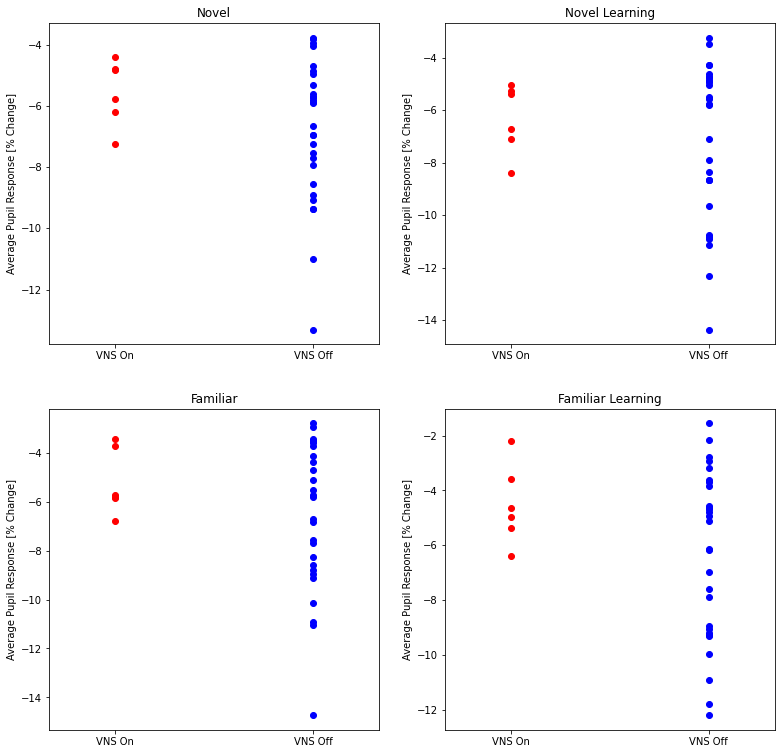

In [16]:
# scatter plots to show the average % change for each session (vns on and vns off)- separated by the 4 trial types
scatter_fig, scatter_axs = plt.subplots(2,2,figsize = (13,13)) # initialize 4 subplots
scatter_axs = scatter_axs.ravel()
x = [1.2,1.8]
labels = ['Novel','Novel Learning','Familiar','Familiar Learning'] # the 4 trial types
for i in range(0, len(labels)):
    y = [(percent_change_on.loc[i]), percent_change_off.loc[i]]
    for xe, ye in zip(x,y):
        if xe == 1.2:
            scatter_axs[i].scatter([xe] * len(ye), ye, c = 'Red')
        elif xe == 1.8:
            scatter_axs[i].scatter([xe] * len(ye), ye, c = 'Blue')
        N = 2
        ind = np.arange(N)
        scatter_axs[i].set_xticks([1.2,1.8])
        scatter_axs[i].set_xlim([1,2])
        scatter_axs[i].set_xticklabels(['VNS On', 'VNS Off'])
        scatter_axs[i].set_title(labels[i])
        scatter_axs[i].set_ylabel('Average Pupil Response [% Change]')
erpd = plt.gcf()
plt.show()
erpd.savefig('erpd.png', dpi = 100)

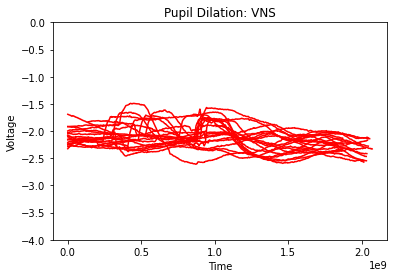

In [96]:
# plot good trials up until time where fp goes off (i.e. animal no longer fixating) --> choose a VNS on session
intro = '00:00:0'
end = '000'
for x in range(0,25): # plotting good trials (i.e. good_trials = 1) from the first 25 trials of this session
    session = vns_on_eye_noBlinks.loc[(vns_on_eye_noBlinks['Session'] == '2019-01-30 16:38:00') & (vns_on_eye_noBlinks['Trial'] == x),'Pupils'].interpolate()
    if (vns_on_trials.loc[(vns_on_trials['Session'] == '2019-01-30 16:38:00'),'good_trials'].loc[x] == 1):
        fp_off = vns_on_trials.loc[(vns_on_trials['Session'] == '2019-01-30 16:38:00'),'time_fp_off'].loc[x]
        fp_off = '%.3f'%(fp_off)
        fp_off = intro + fp_off + end
        session.index.get_loc(fp_off, method = 'nearest') # finding index nearest to the timestamp of fp_off
        plt.plot(session[:fp_off],'r')

plt.ylim(-4,0)
plt.ylabel('Voltage')
plt.xlabel('Time')
plt.title('Pupil Dilation: VNS')
#plt.legend(('1','2','3','4','5'))
vns_fig = plt.gcf()
plt.show()
vns_fig.savefig('dilation_vns_190130.png', dpi = 100)

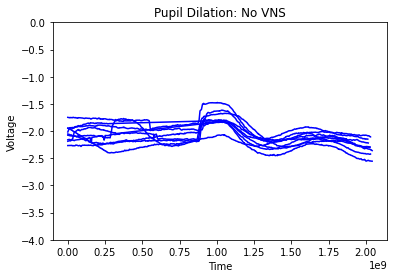

In [97]:
# plot good trials up until time where fp goes off (i.e. animal no longer fixating) --> choose a VNS off session
for x in range(0,25): # plotting good trials (i.e. good_trials = 1) from the first 25 trials of this session
    session = vns_off_eye_noBlinks.loc[(vns_off_eye_noBlinks['Session'] == '2019-01-18 15:58:00') & (vns_off_eye_noBlinks['Trial'] == x),'Pupils'].interpolate()
    if (vns_off_trials.loc[(vns_off_trials['Session'] == '2019-01-18 15:58:00'),'good_trials'].loc[x] == 1):
        fp_off = vns_off_trials.loc[(vns_off_trials['Session'] == '2019-01-18 15:58:00'),'time_fp_off'].loc[x]
        fp_off = '%.3f'%(fp_off)
        fp_off = intro + fp_off + end
        session.index.get_loc(fp_off, method = 'nearest') # finding index nearest to the timestamp of fp_off
        plt.plot(session[:fp_off],'b')

plt.ylim(-4,0)
plt.ylabel('Voltage')
plt.xlabel('Time')
plt.title('Pupil Dilation: No VNS')
noVNS_fig = plt.gcf()
plt.show()
noVNS_fig.savefig('dilation_noVNS_190118.png', dpi = 100)

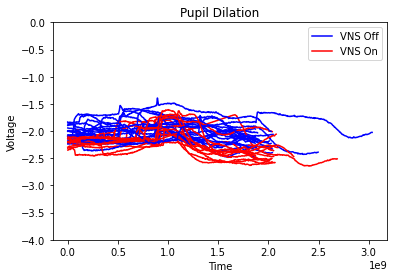

In [98]:
# overlay to show vns on and off on same plot
for x in range(0,25):
    # choose a VNS off session
    session_off = vns_off_eye_noBlinks.loc[(vns_off_eye_noBlinks['Session'] == '2019-01-30 14:59:00') & (vns_off_eye_noBlinks['Trial'] == x),'Pupils'].interpolate()
    if (vns_off_trials.loc[(vns_off_trials['Session'] == '2019-01-30 14:59:00'),'good_trials'].loc[x] == 1):
        fp_off = vns_off_trials.loc[(vns_off_trials['Session'] == '2019-01-30 14:59:00'),'time_fp_off'].loc[x]
        fp_off = '%.3f'%(fp_off)
        fp_off = intro + fp_off + end
        session_off.index.get_loc(fp_off, method = 'nearest')
        plt.plot(session_off[:fp_off],'b')
    # choose a VNS on session
    session_on = vns_on_eye_noBlinks.loc[(vns_on_eye_noBlinks['Session'] == '2019-01-29 16:02:00') & (vns_on_eye_noBlinks['Trial'] == x),'Pupils'].interpolate()
    if (vns_on_trials.loc[(vns_on_trials['Session'] == '2019-01-29 16:02:00'),'good_trials'].loc[x] == 1):
        fp_off = vns_on_trials.loc[(vns_on_trials['Session'] == '2019-01-29 16:02:00'),'time_fp_off'].loc[x]
        fp_off = '%.3f'%(fp_off)
        fp_off = intro + fp_off + end
        session_on.index.get_loc(fp_off, method = 'nearest')
        plt.plot(session_on[:fp_off],'r')
        
plt.ylim(-4,0)
plt.ylabel('Voltage')
plt.xlabel('Time')
plt.title('Pupil Dilation')
plt.legend(('VNS Off','VNS On'))
combined_fig = plt.gcf()
plt.show()
combined_fig.savefig('combined_fig.png', dpi = 100)